In [1]:
import gzip
import pickle
import sys, os
import numpy as np
import matplotlib.pyplot as plt

# Any results you write to the current directory are saved as output.
from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1

11493376/11490434 [==============================] - 1s 0us/step


In [3]:
N, W, H = x_train.shape
D = W * H
x_test = x_test.reshape(-1, D)
x_train = x_train.reshape(-1, D)

assert(len(x_test) == len(y_test))
assert(len(x_train) == len(y_train))

print("No of training examples: ", len(x_train))
print("shape of training examples: ", x_train.shape)

No of training examples:  60000
shape of training examples:  (60000, 784)


In [4]:
# not sure about this
latent_dim = 100

In [5]:
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam

In [6]:
# Get the generator model
def build_generator(latent_dim):
    i = Input(shape=(latent_dim,))
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(D, activation='tanh')(x)
    
    model = Model(i, x)
    
    return model

In [7]:
def build_discriminator(img_size):
    i = Input(shape=(img_size,))
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
    x = Dense(1, activation='sigmoid')(x)
    
    model = Model(i, x)
    
    return model

In [8]:
# Build and compile the discriminator
d_model = build_discriminator(D)
d_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy'])

# Build and compile the combined model
g_model = build_generator(latent_dim)

# Create an input to represent noise sample from latent space
z = Input(shape=(latent_dim,))

# Pass noise through generator to get an image
img = g_model(z)

# Make sure only the generator is trained
d_model.trainable = False

# The true output is fake, but we label them real!
fake_pred = d_model(img)

# Create the combined model object
combined_model = Model(z, fake_pred)

# Compile the combined model
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [9]:
d_losses = []
g_losses = []

epochs = 30000
batch_size = 32
sample_period = 200

ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

if not os.path.exists('gan_images'):
    os.makedirs('gan_images')

In [10]:
# record images after sample period
def sample_images(epoch):
    rows, cols = 5, 5
    noise = np.random.randn(rows * cols, latent_dim)
    assert(noise.shape == (25, latent_dim))
    imgs = g_model.predict(noise)

    # Rescale images 0 - 1
    imgs = 0.5 * imgs + 0.5

    fig, axs = plt.subplots(rows, cols)
    idx = 0
    for i in range(rows):
        for j in range(cols):
            axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
            axs[i,j].axis('off')
            idx += 1
    fig.savefig("gan_images/%d.png" % epoch)
    plt.close()

In [11]:
for epoch in range(epochs):
    
    ###########################
    ### Train discriminator ###
    ###########################
    
    # Select a random batch of images
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_imgs = x_train[idx]
    
    # Generate fake images
    noise = np.random.randn(batch_size, latent_dim)
    fake_imgs = g_model.predict(noise)    

    # Train the discriminator
    # both loss and accuracy are returned
    d_loss_real, d_acc_real = d_model.train_on_batch(real_imgs, ones)
    d_loss_fake, d_acc_fake = d_model.train_on_batch(fake_imgs, zeros)
    
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_acc  = 0.5 * (d_acc_real + d_acc_fake)
    
    ###########################
    ##### Train generator #####
    ###########################

    noise = np.random.randn(batch_size, latent_dim)
    g_loss = combined_model.train_on_batch(noise, ones)
    
    # do it again!
    noise = np.random.randn(batch_size, latent_dim)
    g_loss = combined_model.train_on_batch(noise, ones)
    
    # why not one more time!
    noise = np.random.randn(batch_size, latent_dim)
    g_loss = combined_model.train_on_batch(noise, ones)

    # Save the losses
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    
    if epoch % 500 == 0:
        print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f},  d_acc: {d_acc:.2f},  g_loss: {g_loss:.2f}")
        
    if epoch % sample_period == 0:
        sample_images(epoch)

epoch: 1/30000, d_loss: 0.78,  d_acc: 0.53,  g_loss: 0.80
epoch: 501/30000, d_loss: 0.72,  d_acc: 0.44,  g_loss: 0.66
epoch: 1001/30000, d_loss: 0.71,  d_acc: 0.45,  g_loss: 0.74
epoch: 1501/30000, d_loss: 0.66,  d_acc: 0.70,  g_loss: 0.79
epoch: 2001/30000, d_loss: 0.66,  d_acc: 0.58,  g_loss: 0.77
epoch: 2501/30000, d_loss: 0.72,  d_acc: 0.48,  g_loss: 0.71
epoch: 3001/30000, d_loss: 0.64,  d_acc: 0.58,  g_loss: 0.80
epoch: 3501/30000, d_loss: 0.73,  d_acc: 0.44,  g_loss: 0.75
epoch: 4001/30000, d_loss: 0.67,  d_acc: 0.53,  g_loss: 0.83
epoch: 4501/30000, d_loss: 0.68,  d_acc: 0.61,  g_loss: 0.75
epoch: 5001/30000, d_loss: 0.74,  d_acc: 0.41,  g_loss: 0.79
epoch: 5501/30000, d_loss: 0.67,  d_acc: 0.59,  g_loss: 0.83
epoch: 6001/30000, d_loss: 0.77,  d_acc: 0.41,  g_loss: 0.82
epoch: 6501/30000, d_loss: 0.63,  d_acc: 0.61,  g_loss: 0.79
epoch: 7001/30000, d_loss: 0.66,  d_acc: 0.53,  g_loss: 0.80
epoch: 7501/30000, d_loss: 0.69,  d_acc: 0.56,  g_loss: 0.76
epoch: 8001/30000, d_loss: 0

In [12]:
sample_images(epoch+1)

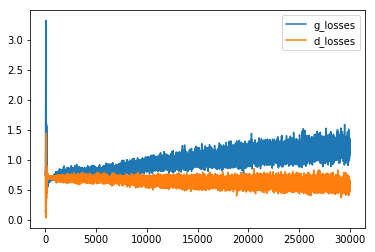

In [13]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

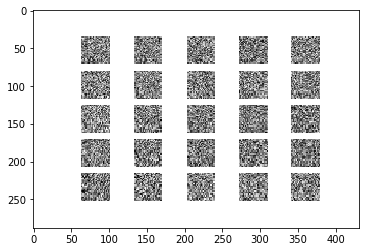

In [14]:
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)

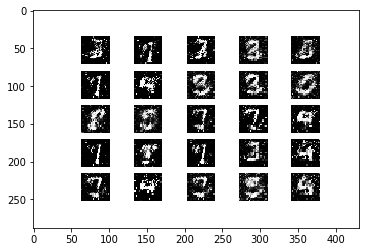

In [15]:
a = imread('gan_images/2000.png')
plt.imshow(a)

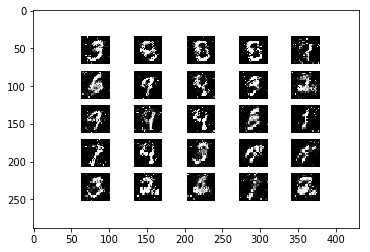

In [16]:
a = imread('gan_images/4000.png')
plt.imshow(a)

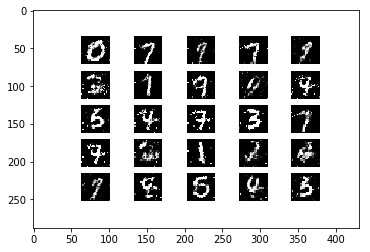

In [17]:
a = imread('gan_images/18000.png')
plt.imshow(a)

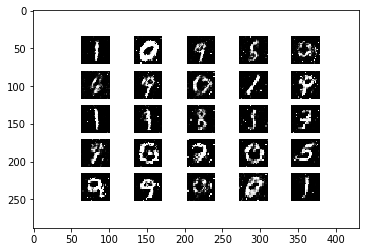

In [18]:
a = imread('gan_images/20000.png')
plt.imshow(a)

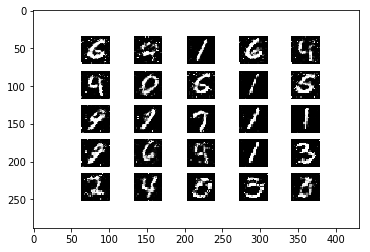

In [19]:
a = imread('gan_images/28000.png')
plt.imshow(a)

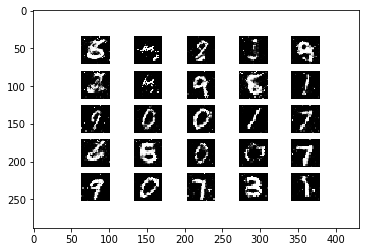

In [20]:
a = imread('gan_images/30000.png')
plt.imshow(a)